# Optical Character Recognition on Ukrainian Dataset

Few weeks before writing this notebook I got an assignment in my university to create 16 images with Ukrainian letters and train a neural network on them. I didn't think it was a good idea to run a learning algorithm on a dataset with just 16 examles. So I told myself "Hey, why don't I use some existing dataset of Ukrainian characters. Of course, there should be something like [MNIST](http://yann.lecun.com/exdb/mnist/)". Surprisingly, no matter how hard I tried, I couldn't find any open dataset of Ukrainian letters (or letters of any other [Cyrillic alphabet](https://en.wikipedia.org/wiki/Cyrillic_alphabets)) that could be used for the purposes of [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition). I've asked some people who work with machine learning, but none of them heard of such dataset. So I decided to create one.

Of course, I couldn't hire hundreds of writers to create a dataset of handwitten letters (though, I am curious if it is possible to [crowdsource](https://en.wikipedia.org/wiki/Crowdsourcing) a project like that), so I wrote a simple bash script that generated thousands of images of printed Ukrainian letters in different fonts and with different rotations. That script was very slow (and really ugly - I hardcoded the entire list of my system fonts by copypasting it from the command line output and manualy removing the fonts that don't support some Ukrainian letters). So in the end I replaced it with a Python notebook that did the same job faster, easier and cleaner. All the sources can be found in my [UkrainianOCR](https://github.com/olekscode/UkrainianOCR) public repository. There are still a lot of things to improve (in fact some of them are literally crying for help), so please, don't hesitate to contribute, leave comments, contact me personally or help in any other way.

This notebook contains examples of some learning algorithms trained on this Ukrainian dataset (if you come up with a better name - tell me; and yes, for so many reasons, any name would be better than __uaset__).

In [55]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Reading and Visualizing the Dataset

In [56]:
df = pd.read_csv("../data/uaset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9966 entries, 0 to 9965
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 59.7 MB


These are 200 randomly selected images from the dataset. You can see that they are presented in different fonts and styles (bold, italic), but the rotations are not applied.

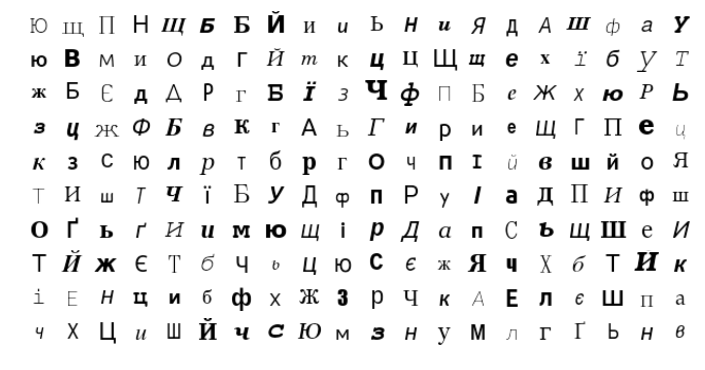

In [57]:
rows = 10
cols = 20

fig = plt.figure(figsize=(12,6))

for i in range(rows):
    for j in range(cols):
        k = np.random.randint(0, len(df))
        
        ax = fig.add_subplot(rows,cols,i*cols + j + 1) 
        ax.set_axis_off()
        ax.imshow(df.iloc[k][1:].reshape([28, 28]), cmap='Greys')

## Splitting the Data into Training and Test Sets

In [58]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [59]:
X_train = df_train[df_train.columns[1:]]
y_train = df_train['label']

X_test = df_test[df_test.columns[1:]]
y_test = df_test['label']

## Data Preprocessing

At this point our images are represented as vectors of 784 integer numbers in the closed interval [0, 255] - 8-bit greyscale images, 28x28. We can look at the unique pixel values of a first image

In [60]:
X_train.iloc[0].unique()

array([  0,   2, 197, 229,  16, 131, 247,  41,  36, 245, 161,  53, 252,
       112, 106, 255,  76,   8, 215, 191,   1, 186, 230,  17, 142, 242,
        32,  28, 240, 253,  99, 115, 216, 213, 237,  94, 144, 244,  40,
       182,  66, 254, 102,  23, 234, 192,   9, 221, 184,  81, 100, 171,
       238,  29, 246, 123, 141])

Learning algorithms perform much better when the data is well scaled (for example, all entries are in the range \[0, 1\] or \[-1, 1\], or have mean 0 and variance 1). It is not in this notebook, but I have trained the classifiers on the unscaled __uaset__, and [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) had an accuracy around 0.8 (that is 10% less than it has now) and the [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) algorithm did not seem to learn at all. 

Luckily, scikit-learn offers great tools for data preprocessing. We will use the _StandardScaler_ to scale our data to some nice range.

In [61]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [62]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now let's visualize a random letter and see how it was scaled.

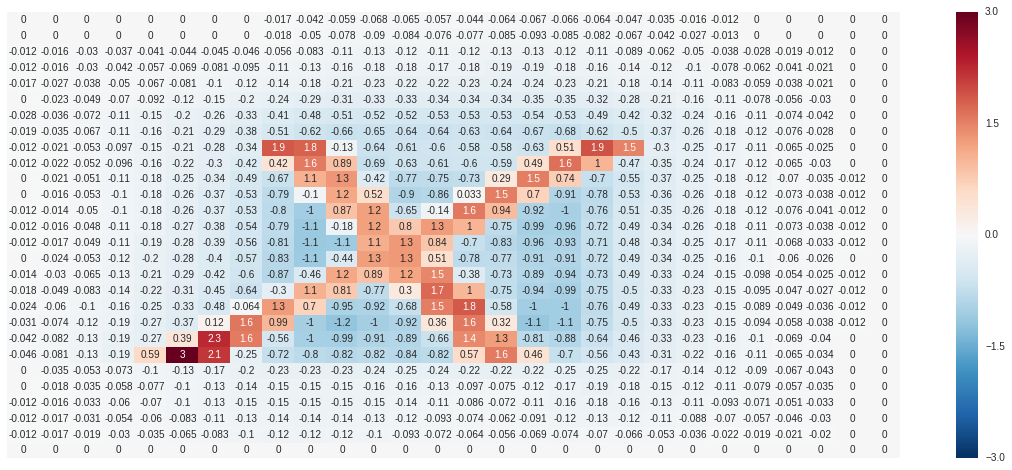

In [63]:
# Index of a random letter from the training set
k = np.random.randint(0, len(X_train))

fig, ax = plt.subplots(figsize=(20,8))

img = X_train[k].reshape([28, 28])

# There is a bug in scikit-learn that makes it impossible to turn on the
# annotations (pixel values) if tick labels are off. So we initialize
# them with the lists of empty strings.
# If you know a cleaner workaround, please, let me know
sns.heatmap(img, ax=ax, xticklabels=[''], yticklabels=[''], annot=True)

## Random Classifier

One of my first attempts to train a neural network on the [MNIST]() dataset resulted in me spending half an hour looking on the screen with blinking output from an algorithm showing the accuracy jumping up and down around 10%. I was so excited "Wow! My algorithm can recognize 10% of the data. Soon it will get better". Of course, it didn't. In fact, it wasn't learning at all. 10% is the probability of correctly classifying an image into one of 10 classes (10 digits) by just picking a random class.

Ukrainian alphabet has 33 letters. Multiply it by 2 (uppercase and lowercase letters) and we get 66 different classes. Which means that the accuracy af random classification should be around 1/66 = ...

In [64]:
1 / 66

0.015151515151515152

Yes. Just like that.

Let's classify our data using scikit-learn's _DummyClassifier_ and picking each class based on [uniform distribution](https://en.wikipedia.org/wiki/Discrete_uniform_distribution)

The next 4 cells represent the typical machine learning workflow:
* Choose a classifier
* Fit it to your training data
* Predict the output on a test data
* Evaluate the results

Fit - Predict - Evaluate

But training accuracy is not the only thing to consider when chosing a learning algorithm. They all need different amount of time to converge, and if some of them ([Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)) converge very fast, others ([Neural Networks](https://en.wikipedia.org/wiki/Multilayer_perceptron)) take quite a while. I measure the execution time of training and prediction by using Jupyter's cell magic _%%time_.

By the way, you can list the availabe cell magic commands by typing _%%lsmagic_ in a cell - these are some truly amazing features of Jupyter notebooks.

In [65]:
clf = DummyClassifier(strategy='uniform')

In [66]:
%%time
clf.fit(X_train, y_train)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.86 ms


DummyClassifier(constant=None, random_state=None, strategy='uniform')

In [67]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.62 ms


In [68]:
accuracy_score(y_test, y_pred)

0.015506232897537246

You can see that the accuracy aquired experimentally is close to our analytical estimation.

If it's not - you've messed with my code. Because it worked for me.

## Naive Bayes Classifier

In [69]:
clf = GaussianNB()

In [70]:
%%time
clf.fit(X_train, y_train)

CPU times: user 172 ms, sys: 40 ms, total: 212 ms
Wall time: 210 ms


GaussianNB(priors=None)

In [71]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 1.75 s, sys: 1.13 s, total: 2.88 s
Wall time: 2.89 s


In [72]:
accuracy_score(y_test, y_pred)

0.37944664031620551

## Support Vector Classifier (SVC)

In [73]:
clf = SVC(gamma=0.001)

In [74]:
%%time
clf.fit(X_train, y_train)

CPU times: user 55.8 s, sys: 40 ms, total: 55.9 s
Wall time: 55.9 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [75]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 31.8 s, sys: 0 ns, total: 31.8 s
Wall time: 31.8 s


In [76]:
accuracy_score(y_test, y_pred)

0.835816357555488

## Multilayer Perceptron Classifier

In [77]:
clf = MLPClassifier()

In [78]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1min 37s, sys: 4.18 s, total: 1min 41s
Wall time: 51.3 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [79]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 77.4 ms


In [80]:
accuracy_score(y_test, y_pred)

0.91213134691395559

## Visualization of Weights

Our neural network has an input layer with 784 neurons (28x28 images), one hidden layer with 100 neurons, and an output layer with 66 neurons (66 classes). It means that we have two weight matrices:
* (784x100) matrix between layer<sub>0</sub> and layer<sub>1</sub>
* (100x66) matrix between layer<sub>1</sub> and layer<sub>2</sub>

First matrix can be visualised as 100 images with 28x28 pixels, and the second one - as 66 images with 10x10 pixels.

Let's define a function that will visualize 16 weight-images for a specified layer.

In [81]:
def show_weights(classifier, layer=0):
    fig, axes = plt.subplots(2, 8, figsize=(16,4))
    
    # Side of a square that will represent a row of the weight matrix
    # should be a square root of the number of columns of this matrix
    # - that is the number of neurons in the previous layer
    n = int(np.sqrt(clf.coefs_[layer].shape[0]))

    vmin, vmax = clf.coefs_[layer].min(), clf.coefs_[layer].max()
    for coef, ax in zip(clf.coefs_[layer].T, axes.ravel()):
        ax.matshow(coef.reshape(n, n), cmap=plt.cm.gray, vmin=.5 * vmin,
                   vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

    plt.show()

You can change the value of *max_iter* to see how the weights look like after, let's say 5 iterations (or 30, or 50 etc.)

In [82]:
%%time
clf = MLPClassifier(max_iter=200)
clf.fit(X_train, y_train)

print("Training set score: %f" % clf.score(X_train, y_train))
print("Test set score: %f" % clf.score(X_test, y_test))

Training set score: 0.999700
Test set score: 0.910611
CPU times: user 1min 16s, sys: 3.16 s, total: 1min 20s
Wall time: 40.3 s


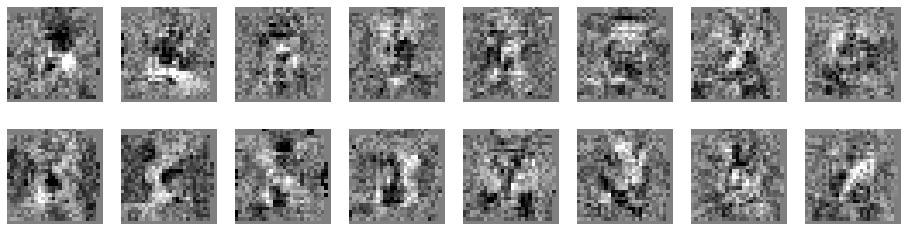

In [83]:
# Visualizing the rows of a weight matrix between layer0 and layer1
show_weights(clf, layer=0)

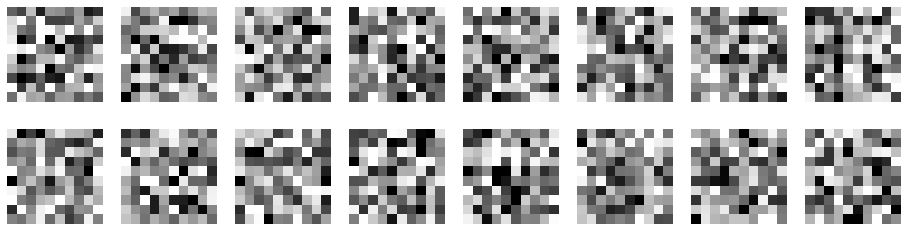

In [84]:
# Visualizing the rows of a weight matrix between layer1 and layer2
show_weights(clf, layer=1)